In [ ]:
from lp_math import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# generate data according to GBM assumptions, and a range of volatilities
def populate_gbm_data(num_steps, num_simulations):
    dt = 0.1
    x0 = 100

    # simulate a range of latent volatility values
    sigma = np.repeat([0.8 + 0.1*i for i in range(20)],num_simulations/20)

    x = np.exp(
        (1 - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), num_steps)).T
    )
    x = np.vstack([np.ones(len(sigma)), x])
    x = x0 * x.cumprod(axis=0)
    return x

# calculate array of realized volatilities (1 per GBM simulation)
def calculate_volatilities(gbm_data):
    ratios = gbm_data[1:][:] / gbm_data[:-1][:]
    log_ratios = np.log(ratios)
    volatilities = np.std(log_ratios, axis=0)

    return volatilities

# calculate array of pool yield (1 per GBM simulation)
def calculate_k_growths(gbm_data, gamma):
    yields = []
    data_points, simulations = gbm_data.shape

    for j in range(simulations):
        rootk = 1
        for i in range(1, data_points):
            old_price = gbm_data[i-1][j]
            new_price = gbm_data[i][j]
            p_0 = old_price if (new_price < old_price) else 1/old_price
            p_1 = new_price if (new_price < old_price) else 1/new_price

            rootk *= calc_rootk_growth(mpf(gamma), mpf(p_0), mpf(p_1)) 
        yields.append(rootk)

    return np.array(yields) 

def plot_gbm_data(gbm_data):
    plt.plot(gbm_data)
    plt.yscale("log",base = 2)
    plt.xlabel("$t$")
    plt.ylabel("$x$")
    plt.title(
        "Realizations of Geometric Brownian Motion with $\mu = 1$ and several variances"
    )
    plt.show()

def plot_yield_data(yields, volatilities):
    plt.xlabel("APY factor")
    plt.ylabel("ln realized volatility")
    plt.title("realized volatility vs LP APY")
    plt.scatter(yields, volatilities)

    plt.show()


In [3]:
gamma = 0.997 # standard 0.3% uniswap pool fee
num_samples, num_simulations = 1000, 1000 # 1000 simulations of 1000 data points each
gbm_data = populate_gbm_data(num_samples, num_simulations)


In [4]:
volatilities = calculate_volatilities(gbm_data)
yields = calculate_k_growths(gbm_data, gamma)

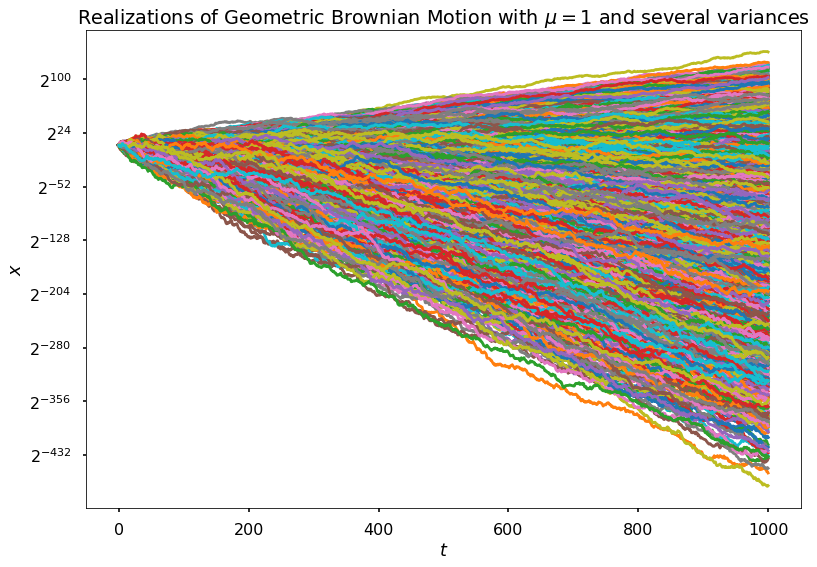

In [5]:
plt.style.use('seaborn-poster')
plot_gbm_data(gbm_data)

num simulations:  1000
correlation:  0.998691885304156


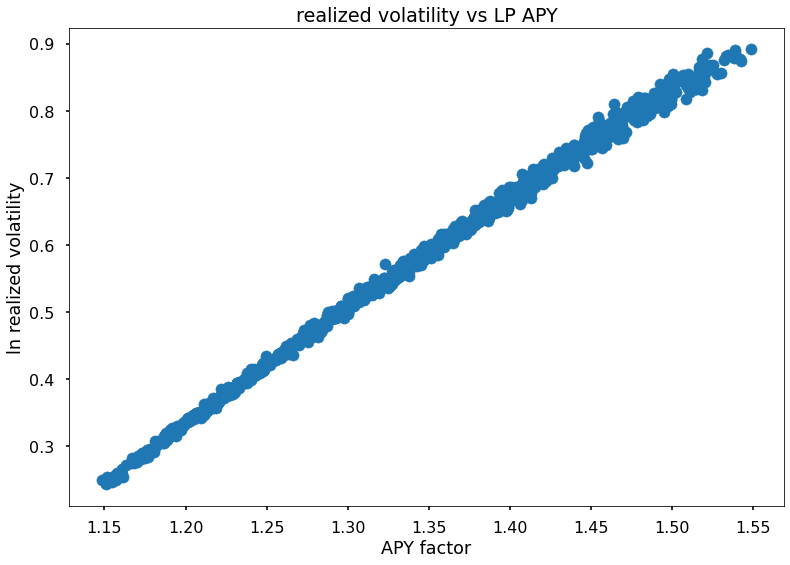

In [6]:
print('num simulations: ', yields.shape[0])
print('correlation: ', np.corrcoef(yields, volatilities)[0,1])
plot_yield_data(yields, volatilities)